# **Music Recommendation System**

# **Milestone 2**

Now that we have explored the data, let's apply different algorithms to build recommendation systems

**Note:** Use the shorter version of the data i.e. the data after the cutoffs as used in Milestone 1.

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems on the basis of the sum of play counts.

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  2000000 non-null  int64 
 1   user_id     2000000 non-null  object
 2   song_id     2000000 non-null  object
 3   play_count  2000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38

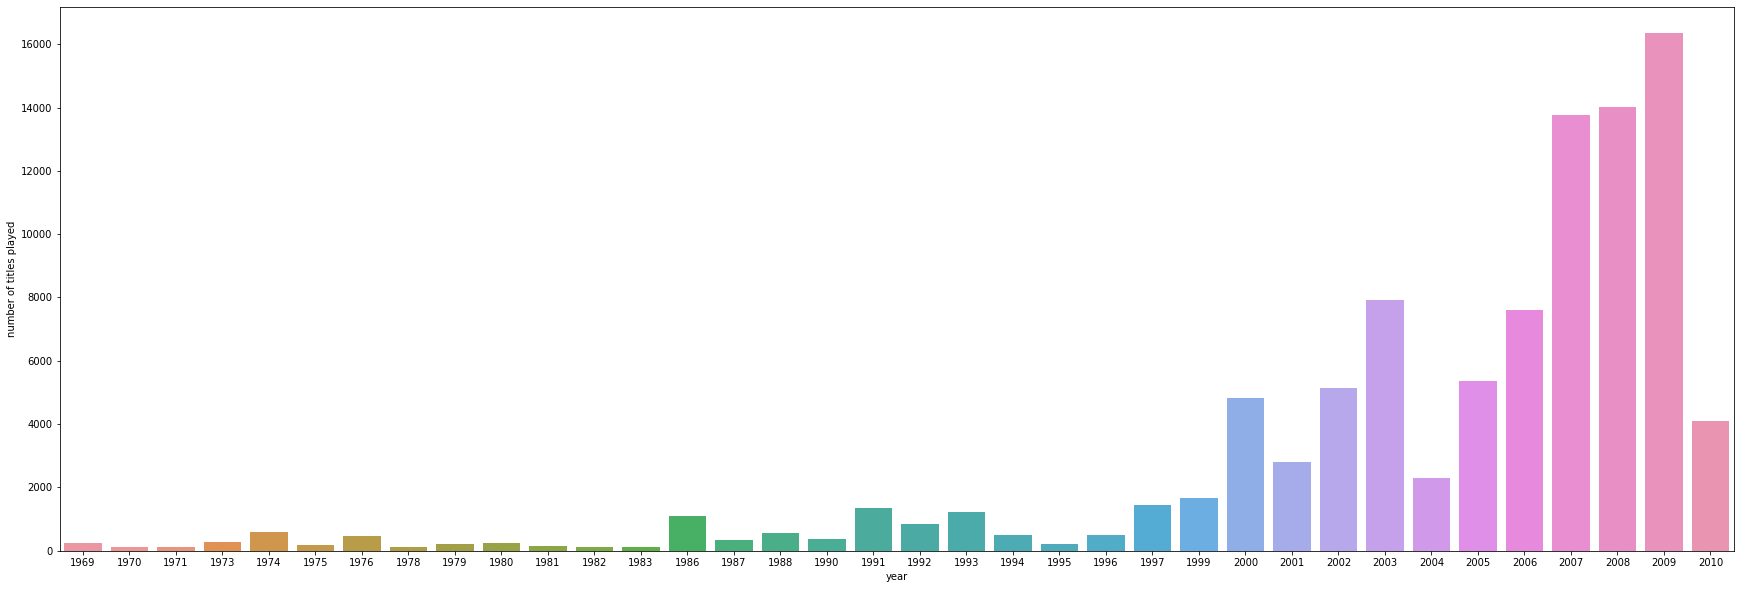

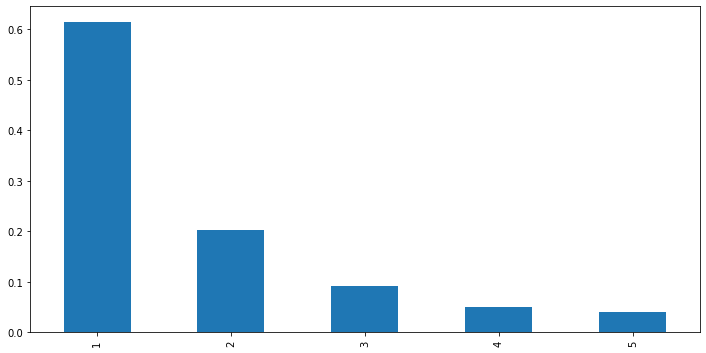

In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/ZhannaSakayeva_Milestone_1_Recommendation_Systems.ipynb'

In [3]:
#Calculating average play_count
average_count = df_final.groupby('song_id').mean()['play_count'] #Hint: Use groupby function on the song_id column. 

#Calculating the frequency a song is played.
play_freq = df_final.groupby('song_id').count()['play_count']#Hint: Use groupby function on the song_id column

In [4]:
#Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count':average_count, 'play_freq':play_freq})
final_play.head()

,avg_count,play_freq
song_id,,
21,1.622642,265
22,1.492424,132
52,1.729216,421
62,1.728070,114
93,1.452174,115


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [5]:
#Build the function for finding top n songs
def top_n_songs(final_play, n, min_playcounts):
    
    # Finding songs with minimum number of interactions
    recommendations = final_play[final_play['play_freq'] > min_playcounts]
    
    # Sorting values with respect to average rating 
    recommendations = recommendations.sort_values(by = 'avg_count', ascending = False)
    
    return recommendations.index[:n]

In [6]:
#Recommend top 10 songs using the function defined above
list(top_n_songs(final_play, 10, 100))

[7224, 6450, 9942, 5531, 5653, 8483, 2220, 657, 614, 352]

We have recommended the top 10 songs based on the average play count of song. Now, let's build a recommendation system using collaborative filtering.

### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity based and subsequent models we will use the "surprise" library.

In [7]:
#Install the surprise package using pip. Uncomment and run the below code to do the same. 
!pip install surprise 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633716 sha256=9e9e46833b6c4cbb11b86f1f87131e501068d600b0d7259973b61a2d14937a53
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [8]:
# Import necessary libraries
# To compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing play_counts, data should be in structure - user; item ; play_count
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

### Some useful functions

The below is the function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [9]:
#The function to calulate the RMSE, precision@k, recall@k and F_1 score. 
def precision_recall_at_k(model, k=30, threshold=1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by chaning the threshold? What is the intuition behind using the threshold value 1.5? 

In [10]:
# Instantiating Reader scale with expected rating scale 
reader = Reader(rating_scale=(0,5)) #use rating scale (0,5)

# loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader) #Take only "user_id","song_id", and "play_count"

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.4, random_state=42) # Take test_size=0.4

**Think About It:** How changing the test size would change the results and outputs?

In [11]:
#Build the default user-user-similarity model
sim_options = {'name': 'cosine',
               'user_based':True}

#KNN algorithm is used to find desired similar items.
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1) #use random_state=1 

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =30.
precision_recall_at_k(sim_user_user) #Use sim_user_user model

RMSE: 1.0878
Precision:  0.396
Recall:  0.692
F_1 score:  0.504


**Observations and Insights:**
- We are getting RMSE 1.0878.
- We also get precision = 39.6%, that means out of all the recommended songs only 39.6% are relevant.
- We get recall = 69.2%, that means out of all the relevant songs only 69.2% are recommended.
- Here F1 score of the model is ~0.504. It indicates that mostly recommended songs were not that relevant and relevant songs were not recommended.

In [12]:
df_final[(df_final['user_id'] == 6958) & (df_final['song_id'] == 1671)]

,user_id,song_id,play_count,title,release,artist_name,year
215,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003


We observe that the play count for user 6958 and song 1671 is 2.

In [13]:
df_final[(df_final['user_id'] == 6958) & (df_final['song_id'] == 3232)]

,user_id,song_id,play_count,title,release,artist_name,year


While user 6958 has not yet interacted with song 3232.

In [14]:
#predicting play_count for a sample user with a listened song.
sim_user_user.predict(6958, 1671, r_ui=2, verbose=True) #use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.80   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8009387435128914, details={'actual_k': 40, 'was_impossible': False})

In [15]:
#predicting play_count for a sample user with a song not-listened by the user.
sim_user_user.predict(6958,3232, verbose=True) #Use user_id 6958 and song_id 3232

user: 6958       item: 3232       r_ui = None   est = 1.64   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.6386860897998294, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**
- The above output shows that the actual play count for the user 6958 and song 1671 is 2, and the predicted play count is 1.8 by this user-user-similarity-based baseline model.
- The predicted play count for the user 6958 and song 3232 is around 1.64 based on this user-user similarity-based baseline model.

Now, let's try to tune the model and see if we can improve the model performance.

In [16]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# fitting the data
gs.fit(data) #Use entire data for GridSearch

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0460548174663973
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [17]:
# Train the best model found in above gridsearch.
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True, 'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =30
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


**Observations and Insights:**
- We are getting RMSE 1.0521, which is only slighter smaller than the baseline model.
- We also get precision = 41.3%, that means out of all the recommended songs only 41.3% are relevant.
- We get recall = 72.1%, that means out of all the relevant songs only 72.1% are recommended.
- Here F1 score of the model is ~0.525. It indicates that mostly recommended songs were not that relevant and relevant songs were not recommended.
- Overall, the metrics have been improved slightly after hyperparamter tuning, but the model performance is not so good. 

In [18]:
#Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui=2
sim_user_user_optimized.predict(6958, 1671,r_ui=2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 24, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.962926073914969, details={'actual_k': 24, 'was_impossible': False})

In [19]:
#Predict the play count for a song that is not listened by the user (with user_id 6958)
sim_user_user_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.45   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4516261428486725, details={'actual_k': 10, 'was_impossible': False})

**Observations and Insights:**
- The predicted play count for user 6958 and song 1671 is around 1.96 and for song 3232 is around 1.45 based on optimized user-user similarity-based model.

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain user?

In [20]:
#Use inner id 0. 
sim_user_user_optimized.get_neighbors(0, 5)

[42, 1131, 17, 186, 249]

Below we will be implementing a function where the input parameters are - 

- data: a **song** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of songs we want to recommend**
- algo: the algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [21]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')
    
    # extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [22]:
#Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine.
recommendations =get_recommendations(df_final, 6958, 5, sim_user_user_optimized)

In [23]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_counts'])

,song_id,predicted_play_counts
0,5531,2.553335
1,317,2.518269
2,4954,2.406776
3,8635,2.396606
4,5943,2.390723


**Observations and Insights:**
- We recommended top 5 songs for the user 6958 with a user-user similarity-based recommendation engine.

### Correcting the play_counts and Ranking the above songs

In [24]:
def ranking_songs(recommendations, final_rating):
  # sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending=False)[['play_freq']].reset_index()

  # merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['song_id', 'predicted_play_counts']), on='song_id', how='inner')

  # rank the songs based on corrected play_counts
  ranked_songs['corrected_play_counts'] = ranked_songs['predicted_play_counts'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_play_counts', ascending = False)
  
  return ranked_songs

**Think About It:** In the above function to make the correction in the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [25]:
#Applying the ranking_songs function on the final_play data. 
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_play_counts,corrected_play_counts
0,5531,618,2.553335,2.513109
2,317,411,2.518269,2.468943
1,5943,423,2.390723,2.342101
3,4954,183,2.406776,2.332854
4,8635,155,2.396606,2.316284


**Observations and Insights:**
- We consider predicted play counts and corrected play counts for each song. 
- In the above-corrected play count formula, we can add the quantity 1/np.sqrt(n) instead of subtracting it to get more optimistic predictions. But here we are subtracting this quantity, as there are some songs with play counts 5 and we can't have a play counts more than 5 for a song.

### Item Item Similarity-based collaborative filtering recommendation systems 

In [26]:
#Apply the item-item similarity collaborative filtering model with random_state=1 and evaluate the model performance.
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0394
Precision:  0.307
Recall:  0.562
F_1 score:  0.397


**Observations and Insights:**
- We are getting RMSE 1.0394.
- We also get precision = 30.7%, that means out of all the recommended songs only 30.7% are relevant.
- We get recall = 56.2%, that means out of all the relevant songs only 56.2% are recommended.
- Here F1 score of the model is ~0.397. It indicates that mostly recommended songs were not that relevant and relevant songs were not recommended.

In [27]:
#predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user.
sim_item_item.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.36   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.3614157231762556, details={'actual_k': 20, 'was_impossible': False})

In [28]:
#Predict the play count for a user that has not listened to the song (with song_id 1671)
sim_item_item.predict(6958, 3232,  verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.38   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.377602711737415, details={'actual_k': 20, 'was_impossible': False})

**Observations and Insights:**
- The predicted play count for user 6958 and song 1671 is around 1.36 and for song 3232 is around 1.38 based on item-item similarity-based model.

In [29]:
#Apply grid search for enhancing model performance

# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [False], "min_support":[2,4]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting the data
gs.fit(data)

# find best RMSE score
print(gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.022799059818044
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameter [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [30]:
#Apply the best modle found in the grid search.
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': False, 'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options , k=30 , min_k=6 , random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0328
Precision:  0.408
Recall:  0.665
F_1 score:  0.506


**Observations and Insights:**
- We are getting RMSE 1.0328.
- We also get precision = 40.8%, that means out of all the recommended songs only 40.8% are relevant.
- We get recall = 66.5%, that means out of all the relevant songs only 66.5% are recommended.
- Here F1 score of the model is ~0.506. It indicates that mostly recommended songs were not that relevant and relevant songs were not recommended.
- The metrics have been slightly improved, but the model performance is still not good.

In [31]:
#Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9634957386781853, details={'actual_k': 10, 'was_impossible': False})

In [32]:
#predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user.
sim_item_item_optimized.predict(6958, 3232,  verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.28   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2759946618244609, details={'actual_k': 10, 'was_impossible': False})

**Observations and Insights:**
- The predicted play count for user 6958 and song 1671 is around 1.96 and for song 3232 is around 1.28 based on optimized item-item similarity-based model.

In [33]:
#Find five most similar users to the user with inner id 0
sim_item_item_optimized.get_neighbors(0, k = 5)

[124, 523, 173, 205, 65]

In [34]:
#Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [35]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_counts'])

,song_id,predicted_play_counts
0,2342,2.653903
1,5101,2.386577
2,139,2.313727
3,7519,2.270864
4,8099,2.212702


In [36]:
#Applying the ranking_songs function. 
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_play_counts,corrected_play_counts
4,2342,111,2.653903,2.558987
2,5101,130,2.386577,2.298871
3,139,119,2.313727,2.222057
1,7519,168,2.270864,2.193712
0,8099,275,2.212702,2.152399


**Observations and Insights:**
- We recommended top 5 songs for the user 6958 with an item-item similarity-based recommendation engine.
- And we also similarly consider predicted and corrected play counts. 

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [37]:
# Build baseline model using svd
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 1.0252
Precision:  0.41
Recall:  0.633
F_1 score:  0.498


In [38]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui=2
svd.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.27   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.267473397214638, details={'was_impossible': False})

In [39]:
# Making prediction for user who has not listened the song (song_id 3232)
svd.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.56   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5561675084403663, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [40]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performe 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0133746292680046
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [41]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs = 30, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 1.0141
Precision:  0.415
Recall:  0.635
F_1 score:  0.502


**Observations and Insights:**
- Here F1 score of the baseline model is 0.498. 
- F1 score for optimized SVD method is 0.502, which is slightly higher than the baseline model.
- The other metrics have been slightly improved, but the model performance is still not good.

In [42]:
#Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671.
svd_optimized.predict(6598, 1671,r_ui=2, verbose=True)

user: 6598       item: 1671       r_ui = 2.00   est = 1.54   {'was_impossible': False}


Prediction(uid=6598, iid=1671, r_ui=2, est=1.5391963151481505, details={'was_impossible': False})

In [43]:
#Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating.
svd_optimized.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.44   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.442548446117648, details={'was_impossible': False})

**Observations and Insights:**
- The predicted play count for user 6958 and song 1671 is around 1.27 and for song 3232 is around 1.56 based on matrix factorization based model.
- The predicted play count for user 6958 and song 1671 is around 1.54 and for song 3232 is around 1.44 based on optimized matrix factorization based model.

In [44]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [45]:
#Ranking songs based on above recommendations
ranking_songs(svd_recommendations,final_play)

,song_id,play_freq,predicted_play_counts,corrected_play_counts
2,7224,107,2.601899,2.505225
1,5653,108,2.108728,2.012502
4,8324,96,2.014091,1.912029
0,9942,150,1.940115,1.858465
3,6450,102,1.952493,1.853478


**Observations and Insights:**
- We recommended top 5 songs for the user 6958 with matrix factorization based recommendation engine.
- And we also similarly consider predicted and corrected play counts. 

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [46]:
# Make baseline clustering model
# Using CoClustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0487
Precision:  0.397
Recall:  0.582
F_1 score:  0.472


In [47]:
#Making prediction for user_id 6958 and song_id 1671.
clust_baseline.predict(6598, 1671, r_ui = 2, verbose = True)

user: 6598       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid=6598, iid=1671, r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [48]:
#Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user.
clust_baseline.predict(6598, 3232, verbose = True)

user: 6598       item: 3232       r_ui = None   est = 1.70   {'was_impossible': False}


Prediction(uid=6598, iid=3232, r_ui=None, est=1.6989607635206787, details={'was_impossible': False})

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [49]:
# set the parameter space to tune
param_grid = {'n_cltr_u':[5,6,7,8], 'n_cltr_i': [5,6,7,8], 'n_epochs': [10,20,30]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0598983499683625
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 10}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [50]:
# Train the tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 5, n_cltr_i = 5, n_epochs = 10, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0654
Precision:  0.394
Recall:  0.566
F_1 score:  0.465


**Observations and Insights:**
- Here F1 score of the baseline model is 0.472
- F1 score for optimized clustering-based method is 0.465, which is worse than the baseline model.
- The performance is not good for tuned clustering method.



In [51]:
#Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671.
clust_tuned.predict(6598, 1671, r_ui = 2, verbose = True)

user: 6598       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid=6598, iid=1671, r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [52]:
#Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating.
clust_tuned.predict(6598, 3232, verbose = True)

user: 6598       item: 3232       r_ui = None   est = 1.70   {'was_impossible': False}


Prediction(uid=6598, iid=3232, r_ui=None, est=1.6989607635206787, details={'was_impossible': False})

**Observations and Insights:**
- The predicted play count for user 6958 and song 1671 is around 1.7 and for song 3232 is around 1.7 based on clustering-based model.
- The predicted play count for user 6958 and song 1671 is around 1.7 and for song 3232 is around 1.7 based on optimized clustering-based model.

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [53]:
#Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm.
clustering_recommendations = get_recommendations(df_final, 6958, 5, clust_tuned)

### Correcting the play_count and Ranking the above songs

In [54]:
#Ranking songs based on above recommendations
ranking_songs(clustering_recommendations, final_play)

,song_id,play_freq,predicted_play_counts,corrected_play_counts
4,7224,107,3.711503,3.614829
3,5653,108,2.903883,2.807658
0,6860,169,2.691043,2.614120
1,657,151,2.606354,2.524975
2,8483,123,2.582807,2.492640


**Observations and Insights:**
- We recommended top 5 songs for the user 6958 with clustering based recommendation engine.
- And we also similarly consider predicted and corrected play counts. 

### Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [55]:
df_small = df_final

In [56]:
# Concatenate the "title","release","artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']

df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,text
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence Distillation Erin McKeown
202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine Sawdust The Ki...
203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album) Vampire Weekend Vamp...
204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow You Tiny Vipers Tiny Vipers
205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey Man You Know I'm No Good Amy Winehouse


In [57]:
#Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]

#drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset = ['title'])

#Set the title column as the index
df_small = df_small.set_index('title')

# see the first 5 records of the df_small dataset
df_small.head()

,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [58]:
df_small.shape

(561, 4)

In [59]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)
indices[:5]

0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2          I Stand Corrected (Album)
3              They Might Follow You
4                         Monkey Man
Name: title, dtype: object

In [60]:
#Importing necessary packages to work with text data
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We will create a **function to pre-process the text data:**

In [61]:
# Function to tokenize the text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in stopwords.words("english")] #Use stopwords of english
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [62]:
#Create tfidf vectorizer 
tfidf = TfidfVectorizer(tokenizer = tokenize)
# Fit_transfrom the above vectorizer on the text column and then convert the output into an array.
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
# Compute the cosine similarity for the tfidf above output
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Let us see the above array
similar_songs

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

 Finally, let's create a function to find most similar songs to recommend for a given song

In [65]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])
        
    return recommended_songs

Recommending 10 songs similar to Learn to Fly

In [66]:
# Make the recommendation for the song with title 'Learn To Fly'
recommendations('Learn To Fly', similar_songs)

[509, 234, 423, 345, 394, 370, 371, 372, 373, 375]


['Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Under The Gun',
 'I Need A Dollar',
 'Feel The Love',
 'All The Pretty Faces',
 'Bones']

**Observations and Insights:**
- We get 10 songs similar to Learn to Fly and I think it implies that the resulting recommendation system is working well.

## **Conclusion and Recommendations:** 

- **Refined Insights -** What are the most meaningful insights from the data relevant to the problem?

- **Comparison of various techniques and their relative performance -** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- **Proposal for the final solution design -** What model do you propose to be adopted? Why is this the best solution to adopt?